In [60]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from joblib import Parallel, delayed
from datetime import datetime, timedelta

from tqdm import tqdm
from datetime import datetime, timedelta

import lightgbm as lgb
import math

In [4]:
df = pd.read_pickle('./alpha158_tw50.pkl')
features = df.columns.difference(['LABEL0'])
label_column = 'LABEL0'
sequence_length = 22
# drop 3 months data
start_date = df.index.get_level_values('datetime').min() + pd.DateOffset(months=3)
df = df[df.index.get_level_values('datetime') >= start_date]

In [55]:
class CustomDataset(Dataset):
    def __init__(self, data, sequence_length, features, label_column, n_jobs=-1):
        self.sequence_length = sequence_length
        self.features = features
        self.label_column = label_column
        self.dates = data.index.get_level_values('datetime').sort_values().unique()
        self.date_idx = {date: i-sequence_length for i, date in enumerate(self.dates) if i >= sequence_length}
        self.data = data
        self.n_jobs = n_jobs
        self.sequences, self.labels = self.create_sequences_by_date()

    def process_date(self, i):
        sequences = []
        labels = []
        if i + self.sequence_length >= len(self.dates):
            return sequences, labels
        start_date = self.dates[i]
        end_date = self.dates[i + self.sequence_length]
        day_data = self.data.loc[(self.data.index.get_level_values('datetime') >= start_date) &
                                 (self.data.index.get_level_values('datetime') < end_date)]
        for instrument in day_data.index.get_level_values('instrument').unique():
            instrument_data = day_data.xs(instrument, level='instrument')
            instrument_data = instrument_data.ffill().bfill()
            if instrument_data.isna().sum().sum() > 0 or len(instrument_data) != self.sequence_length:
                continue
            seq = instrument_data[self.features].to_numpy()
            label = instrument_data[self.label_column].iloc[-1]
            sequences.append(seq)
            labels.append(label)
        return sequences, labels

    def create_sequences_by_date(self):
        results = Parallel(n_jobs=self.n_jobs)(delayed(self.process_date)(i) for i in range(len(self.dates)))
        all_sequences = [sequences for sequences, _ in results]
        all_labels = [labels for _, labels in results]
        return all_sequences, all_labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx], self.labels[idx]
        sequence = np.array(sequence)
        return torch.tensor(sequence, dtype=torch.float), torch.tensor(label, dtype=torch.float)

class CustomDataLoader:
    def __init__(self, dataset, start_date=None, end_date=None):
        self.dates_idx = dataset.date_idx
        if start_date is None:
            self.start_idx = 0
        else:
            if isinstance(start_date, str):
                start_date = pd.to_datetime(start_date)
            start_date = min([date for date in self.dates_idx.keys() if date >= start_date], 
                             key=lambda x: abs(x - start_date))
            self.start_idx = self.dates_idx[start_date]

        if end_date is None:
            self.end_idx = len(dataset) - 1
        else:
            if isinstance(end_date, str):
                end_date = pd.to_datetime(end_date)
            end_date = min([date for date in self.dates_idx.keys() if date <= end_date],
                           key=lambda x: abs(x - end_date))
            self.end_idx = self.dates_idx[end_date]
        self.dataset = dataset
        self.dates = list(self.dates_idx.keys())[self.start_idx:self.end_idx + 1]

    def __iter__(self):
        for i in range(self.start_idx, self.end_idx + 1):
            yield self.dataset[i][0], self.dataset[i][1]
    
    def get_dates(self):
        return self.dates

In [56]:
# model
class GRU(nn.Module):
    def __init__(self, input_size, gru_hidden_size, gru_num_layers, gru_dropout=0.1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=gru_hidden_size,
            num_layers=gru_num_layers,
            batch_first=True,
            dropout=gru_dropout
        )
        self.fc1 = nn.Linear(gru_hidden_size, gru_hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(gru_hidden_size // 2, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_num_layers, lstm_dropout=0.1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=lstm_dropout
        )
        self.fc1 = nn.Linear(lstm_hidden_size, lstm_hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(lstm_hidden_size // 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class LR(nn.Module):
    def __init__(self, input_size):
        super(LR, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        # shape of x: batch * time_step * feature
        # fatten to batch * (time_step * feature)
        x = x.reshape(x.shape[0], -1)
        out = self.fc(x)
        return out
  
class ModelTraining:
    def __init__(self, 
                 model, 
                 lr, 
                 train_loader, 
                 valid_loader, 
                 epochs, 
                 loss='mse', 
                 metric="", 
                 early_stopping_patience=5, 
                 T_0=5, 
                 T_mult=2, 
                 eta_min=1e-6,
                 checkpoint_path='model_checkpoint.pt',
                 if_scheduler=True,
                 if_ts_norm=True,
                 if_cs_norm=True):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.early_stopping_patience = early_stopping_patience
        self.checkpoint_path = checkpoint_path
        self.loss = loss
        self.metric = metric
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.best_valid_loss = float('inf')
        self.early_stopping_counter = 0
        self.if_scheduler = if_scheduler
        self.if_ts_norm = if_ts_norm
        self.if_cs_norm = if_cs_norm
        self.scheduler = CosineAnnealingWarmRestarts(self.optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min)

    def pearson_correlation_loss(self, outputs, targets):
        outputs = outputs.squeeze()
        targets = targets.squeeze()
        outputs_mean = outputs - torch.mean(outputs)
        targets_mean = targets - torch.mean(targets)
        numerator = torch.sum(outputs_mean * targets_mean)
        denominator = torch.sqrt(torch.sum(outputs_mean ** 2)) * torch.sqrt(torch.sum(targets_mean ** 2))
        return - numerator / denominator
    
    def loss_fn(self, pred, label):
        mask = ~torch.isnan(label)
        if self.loss == "mse":
            return nn.MSELoss()(pred[mask], label[mask])
        elif self.loss == "ic":
            return self.pearson_correlation_loss(pred[mask], label[mask])
        raise ValueError(f"unknown loss function: {self.loss}")

    def metric_fn(self, pred, label):
        mask = torch.isfinite(label)
        if self.metric == "" or self.metric == "loss":
            return self.loss_fn(pred[mask], label[mask])
        elif self.metric == "mse":
            return nn.MSELoss()(pred[mask], label[mask])
        elif self.metric == "ic":
            return self.pearson_correlation_loss(pred[mask], label[mask])
        raise ValueError(f"unknown metric function: {self.metric}")
 
    def train_epoch(self):
        self.model.train()
        train_losses = []
        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            if self.if_ts_norm:
                inputs = (inputs - torch.mean(inputs, dim=1, keepdim=True)) / (torch.std(inputs, dim=1, keepdim=True) + 1e-6)
                inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)
            if self.if_cs_norm:
                inputs = (inputs - torch.mean(inputs, dim=0, keepdim=True)) / (torch.std(inputs, dim=0, keepdim=True) + 1e-6)
                inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs.squeeze(), targets)
            loss.backward()
            # to clip gradient
            # torch.nn.utils.clip_grad_value_(self.GRU_model.parameters(), 3.0)
            self.optimizer.step()
            train_losses.append(loss.item())
        return np.mean(train_losses)

    def validate_epoch(self):
        self.model.eval()
        valid_losses = []
        with torch.no_grad(): # no gradient update
            for inputs, targets in self.valid_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                if self.if_ts_norm:
                    inputs = (inputs - torch.mean(inputs, dim=1, keepdim=True)) / (torch.std(inputs, dim=1, keepdim=True) + 1e-6)
                    inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)
                if self.if_cs_norm:
                    inputs = (inputs - torch.mean(inputs, dim=0, keepdim=True)) / (torch.std(inputs, dim=0, keepdim=True) + 1e-6)
                    inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)
                outputs = self.model(inputs)
                loss = self.metric_fn(outputs.squeeze(), targets)
                valid_losses.append(loss.item())
        return np.mean(valid_losses)

    def train(self):
        for epoch in range(self.epochs):
            train_loss = self.train_epoch()
            valid_loss = self.validate_epoch()
            if self.if_scheduler:
                self.scheduler.step(epoch) 
            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.5f}, Valid Loss: {valid_loss:.5f}')
            
            if valid_loss < self.best_valid_loss:
                self.best_valid_loss = valid_loss
                self.early_stopping_counter = 0
                torch.save(self.model.state_dict(), self.checkpoint_path)
                print(f'Improved validation loss to {valid_loss:.5f}, saving model...')
            else:
                self.early_stopping_counter += 1
                print(f'Validation loss did not improve, counter: {self.early_stopping_counter}/{self.early_stopping_patience}')
                if self.early_stopping_counter >= self.early_stopping_patience:
                    print('Early stopping triggered.')
                    break
                
    def test(self, test_loader):
        self.model.load_state_dict(torch.load(self.checkpoint_path))
        self.model.eval()
        test_ic = []
        preds_actual = []
        test_dates = test_loader.get_dates()
        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                if self.if_ts_norm:
                    inputs = (inputs - torch.mean(inputs, dim=1, keepdim=True)) / (torch.std(inputs, dim=1, keepdim=True) + 1e-6)
                    inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)
                if self.if_cs_norm:
                    inputs = (inputs - torch.mean(inputs, dim=0, keepdim=True)) / (torch.std(inputs, dim=0, keepdim=True) + 1e-6)
                    inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)
                outputs = self.model(inputs)
                loss = - self.metric_fn(outputs.squeeze(), targets)
                test_ic.append([test_dates[idx], loss.item()])
                preds_actual.extend([[test_dates[idx], outputs[i].detach().item(),  targets[i].detach().item()] for i in range(len(outputs))])
        ic_df = pd.DataFrame(test_ic, columns=['datetime', 'ic'])
        preds_df = pd.DataFrame(preds_actual, columns=['datetime', 'pred', 'actual'])
        return ic_df, preds_df
    
    def load_checkpoint(self):
        self.model.load_state_dict(torch.load(self.checkpoint_path))
    
    def get_model(self):
        return self.model

In [57]:
def parse_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

def get_periods(test_start_date, test_end_date, test_period, valid_period, train_period):
    start_date = parse_date(test_start_date)
    end_date = parse_date(test_end_date)
    periods = []
    while start_date <= end_date:
        test_start = start_date
        test_end = start_date + timedelta(days=test_period) - timedelta(days=1)
        valid_start = test_start - timedelta(days=valid_period)
        valid_end = test_start - timedelta(days=1)
        train_start = valid_start - timedelta(days=train_period)
        train_end = valid_start - timedelta(days=1)
        periods.append({
            'train_period': (train_start.strftime('%Y-%m-%d'), train_end.strftime('%Y-%m-%d')),
            'valid_period': (valid_start.strftime('%Y-%m-%d'), valid_end.strftime('%Y-%m-%d')),
            'test_period': (test_start.strftime('%Y-%m-%d'), test_end.strftime('%Y-%m-%d')),
        })
        start_date += timedelta(days=test_period)
    return periods

In [6]:
df = df[df.index.get_level_values('datetime') >= '2023-01-01']
df = df[~df['LABEL0'].isna()]
df = df.fillna(0)
dataset = CustomDataset(df, sequence_length, features, label_column, n_jobs=-1)

In [86]:
def main(all_dates_set, dataset, model):
    ic_l = []
    preds_l = []
    for subset in tqdm(all_dates_set):
        train_loader = CustomDataLoader(dataset, start_date=subset['train_period'][0], end_date=subset['train_period'][1])
        valid_loader = CustomDataLoader(dataset, start_date=subset['valid_period'][0], end_date=subset['valid_period'][1])
        test_loader = CustomDataLoader(dataset, start_date=subset['test_period'][0], end_date=subset['test_period'][1])
        trainer = ModelTraining(model=model,
                                lr=1e-4, 
                                loss='mse', 
                                metric="ic",
                                train_loader=train_loader, 
                                valid_loader=valid_loader, 
                                epochs=30,
                                early_stopping_patience=5,
                                T_0=5,
                                T_mult=2, 
                                eta_min=1e-6,
                                if_scheduler=True,
                                if_ts_norm=False,
                                if_cs_norm=False)
        trainer.train()
        ic, preds = trainer.test(test_loader)
        ic_l.append(ic)
        preds_l.append(preds)
    return pd.concat(ic_l), pd.concat(preds_l)

def plot_cumic(ic_df):
    if 'datetime' in ic_df.columns:
        ic_df.set_index('datetime', inplace=True)
    ic_df.cumsum().plot()
    
def calculate_returns(pred_df, ret_l, ret_s):
    df = pred_df.copy()
    df['trade'] = np.nan
    df.loc[df['pred'] > ret_l, 'trade'] = 1  
    df.loc[df['pred'] < ret_s, 'trade'] = -1 
    df['returns'] = df['trade'] * df['actual']
    df['long_count'] = df['trade'].apply(lambda x: 1 if x > 0 else 0)
    df['short_count'] = df['trade'].apply(lambda x: 1 if x < 0 else 0)
    long_count = df.groupby('datetime')['long_count'].sum()
    short_count = df.groupby('datetime')['short_count'].sum()
    daily_returns = df.groupby('datetime')['returns'].mean()
    return pd.DataFrame({'long_count': long_count, 'short_count': short_count, 'daily_returns': daily_returns})

def random_trade(preds_df):
    df = preds_df.copy()
    df['trade'] = np.random.choice([-1, np.nan, 1], size=len(df))
    df['returns'] = df['trade'] * df['actual']
    df['long_count'] = df['trade'].apply(lambda x: 1 if x > 0 else 0)
    df['short_count'] = df['trade'].apply(lambda x: 1 if x < 0 else 0)
    long_count = df.groupby('datetime')['long_count'].sum()
    short_count = df.groupby('datetime')['short_count'].sum()
    daily_returns = df.groupby('datetime')['returns'].mean()
    return pd.DataFrame({'long_count': long_count, 'short_count': short_count, 'daily_returns': daily_returns})

def plot_cumret(preds_df, ret_l, ret_s, if_random_trade=False):
    if if_random_trade:
        daily_return = random_trade(preds_df)
    else:
        daily_return = calculate_returns(preds_df, ret_l, ret_s)
    daily_return['daily_returns'].fillna(0).cumsum().plot()
    return daily_return

def analyze_annual_returns(df, if_count=False):
    if not isinstance(df.index, pd.DatetimeIndex):
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)

    avg_counts = df[['long_count', 'short_count']].resample('Y').mean()
    df['cumulative_returns'] = (1 + df['daily_returns']).cumprod()
    annual_returns = df['cumulative_returns'].resample('Y').last()
    years = (annual_returns.index[-1] - annual_returns.index[0]).days / 365.25
    annualized_returns = annual_returns.pow(1/years) - 1
    annual_volatility = df['daily_returns'].resample('Y').std() * (252**0.5)  
    sharpe_ratio = annualized_returns / annual_volatility
    results = pd.DataFrame({
        'Average Long Count': avg_counts['long_count'],
        'Average Short Count': avg_counts['short_count'],
        'Annualized Return': annualized_returns,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio
    })
    overall_avg_long_count = df['long_count'].mean()
    overall_avg_short_count = df['short_count'].mean()
    overall_annualized_return = (df['cumulative_returns'].iloc[-1]) ** (1/years) - 1
    overall_annual_volatility = df['daily_returns'].std() * (252**0.5)
    overall_sharpe_ratio = overall_annualized_return / overall_annual_volatility

    # Add a row for overall statistics
    results.loc['Overall'] = [
        overall_avg_long_count,
        overall_avg_short_count,
        overall_annualized_return,
        overall_annual_volatility,
        overall_sharpe_ratio
    ]
    if if_count:
        results = results[['Average Long Count', 'Average Short Count']]
    else:
        results = results[['Annualized Return', 'Annual Volatility', 'Sharpe Ratio']]
    return results

In [ ]:
all_dates_set = get_periods('2020-01-01', '2023-09-30', 90, 90, 360 * 8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRU(input_size=158, gru_hidden_size=64, gru_num_layers=1, gru_dropout=0.3).to(device)
gru_ic_df, gru_preds_df = main(all_dates_set, dataset, gru_model)
gru_ic_df.to_pickle('./gru_ic_df.pkl')
gru_preds_df.to_pickle('./gru_preds_df.pkl')

all_dates_set = get_periods('2020-01-01', '2023-09-30', 90, 90, 360 * 8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTM(input_size=158, lstm_hidden_size=64, lstm_num_layers=1, lstm_dropout=0.3).to(device)
lstm_ic_df, lstm_preds_df = main(all_dates_set, dataset, lstm_model)
lstm_ic_df.to_pickle('./lstm_ic_df.pkl')
lstm_preds_df.to_pickle('./lstm_preds_df.pkl')

all_dates_set = get_periods('2020-01-01', '2023-09-30', 90, 90, 360 * 8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_model = LR(input_size=158*22).to(device)
lr_ic_df, lr_preds_df = main(all_dates_set, dataset, lr_model)
lr_ic_df.to_pickle('./lr_ic_df.pkl')
lr_preds_df.to_pickle('./lr_preds_df.pkl')

Average Long Count     3.659558
Average Short Count    0.969535
Name: Overall, dtype: float64

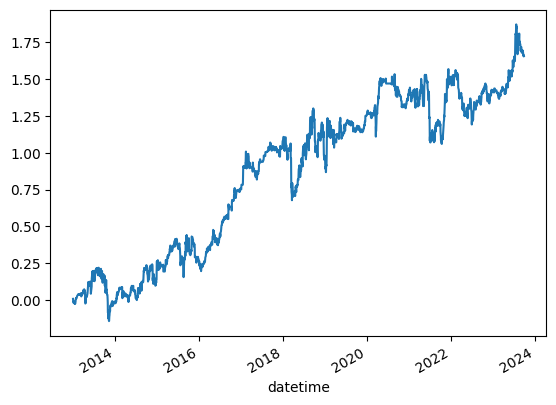

In [101]:
gru_preds_df = pd.read_pickle('./gru_preds_df.pkl')
# test different threshold influence on long short count
    

Annualized Return    0.158847
Annual Volatility    0.269139
Sharpe Ratio         0.590203
Name: Overall, dtype: float64

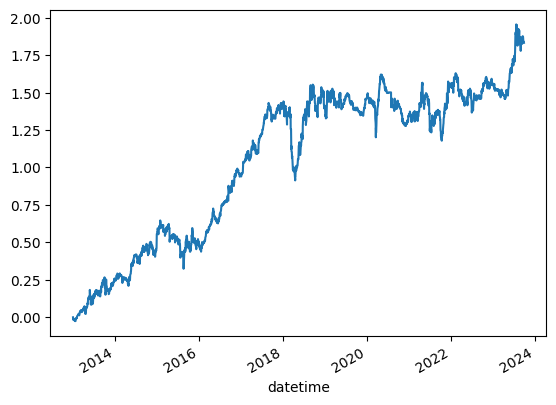

In [90]:
gru_preds_df = pd.read_pickle('./gru_preds_df.pkl')
daily_return = plot_cumret(gru_preds_df, 0.004, -0.004)
analyze_annual_returns(daily_return, if_count=False).iloc[-1]

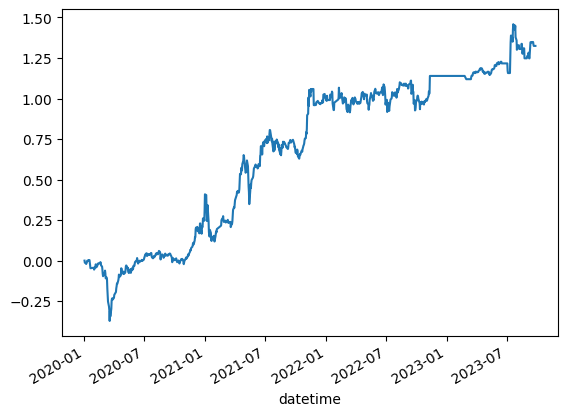

In [6]:
plot_cumret(gru_preds_df, 0.003, -100)

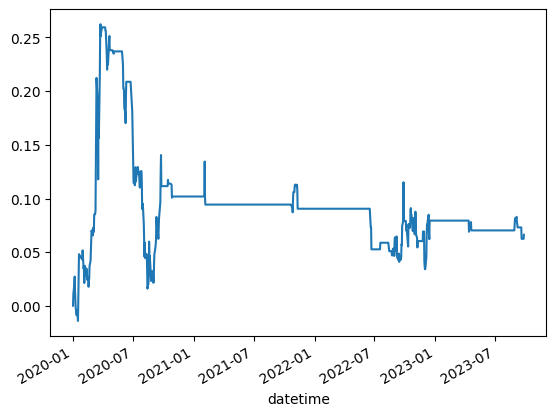

In [8]:
plot_cumret(gru_preds_df, 100, -0.003) 

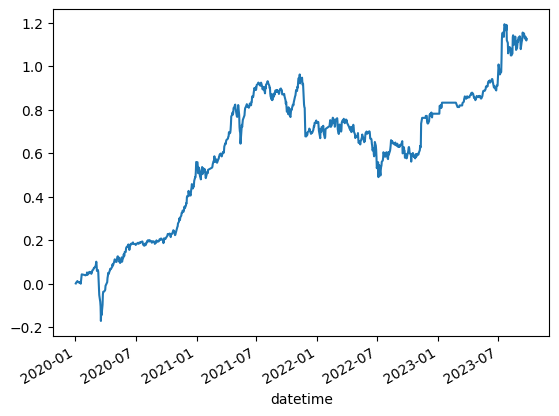

In [7]:
plot_cumret(gru_preds_df, 0.002, -0.003)

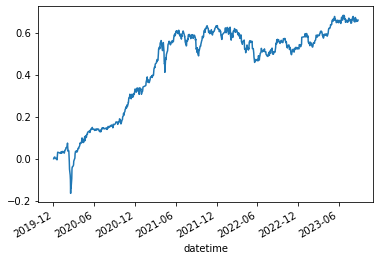

In [38]:
plot_cumret(gru_preds_df, 0.001, -0.001)

In [111]:
lstm_preds_df = pd.read_pickle('./lstm_preds_df.pkl')
lstm_preds_df

,datetime,pred,actual
0,2013-01-02,0.004764,0.008272
1,2013-01-02,0.008128,0.004791
2,2013-01-02,-0.001507,-0.003851
3,2013-01-02,0.000983,0.001338
4,2013-01-02,0.001192,0.000000
...,...,...,...
3518,2023-09-26,0.002337,-0.009381
3519,2023-09-26,0.001265,0.007605
3520,2023-09-26,0.001465,-0.005848
3521,2023-09-26,0.000992,-0.017007


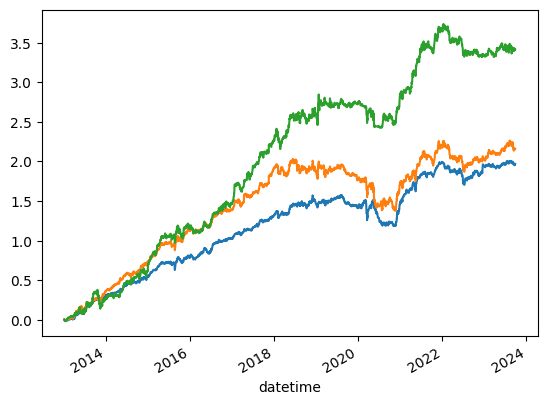

In [119]:
sx = [0.002, 0.003, 0.004]
count_list = []
return_list = []
for x in sx:
    daily_return = plot_cumret(lstm_preds_df, x, -x)
    count = analyze_annual_returns(daily_return, if_count=True).iloc[-1]
    count.name = x
    count_list.append(count)
    
    ret = analyze_annual_returns(daily_return, if_count=False).iloc[-1]
    ret.name = x
    return_list.append(ret)

count_concat = pd.concat(count_list, axis=1).T
ret_concat = pd.concat(return_list, axis=1).T
count_concat.index.name = 'Threshold'
ret_concat.index.name = 'Threshold'
# add index


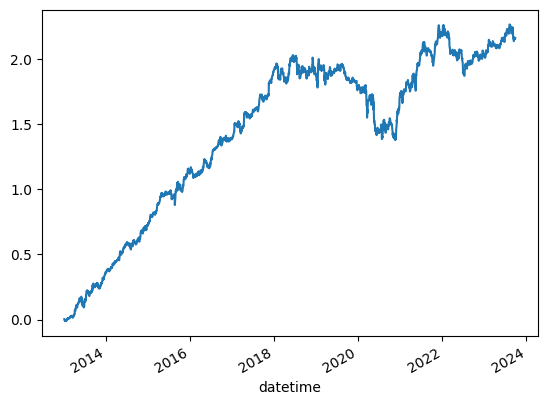

In [74]:
plot_cumret(lstm_preds_df, 0.003, -0.003)

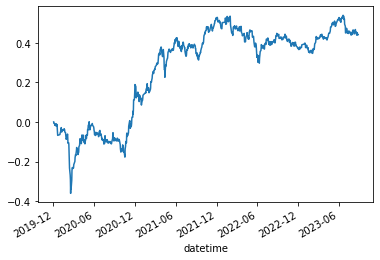

In [43]:
plot_cumret(lstm_preds_df, 0.002, -0.002)

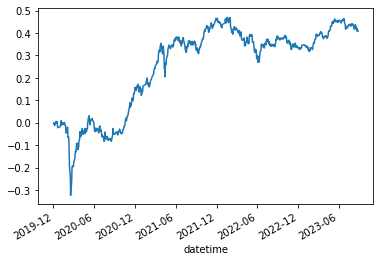

In [44]:
plot_cumret(lstm_preds_df, 0.001, -0.001)

Annualized Return    0.035595
Annual Volatility    0.115418
Sharpe Ratio         0.308406
Name: Overall, dtype: float64

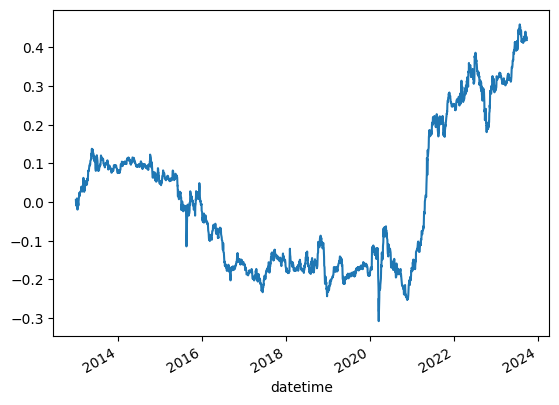

In [97]:
lr_preds_df = pd.read_pickle('./lr_preds_df.pkl')
daily_return = plot_cumret(lr_preds_df, 0.004, -0.004)
analyze_annual_returns(daily_return, if_count=False).iloc[-1]

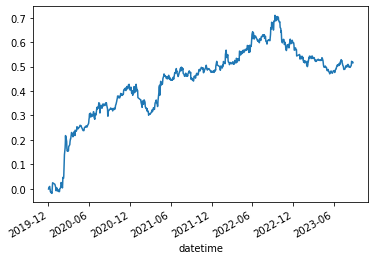

In [46]:
plot_cumret(lr_preds_df, 0.002, -0.002)

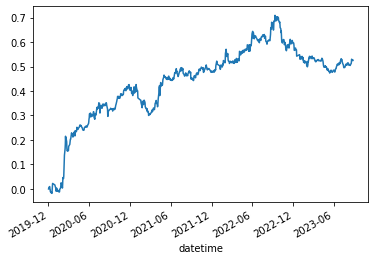

In [48]:
plot_cumret(lr_preds_df, 0.001, -0.001)

## Random Trade

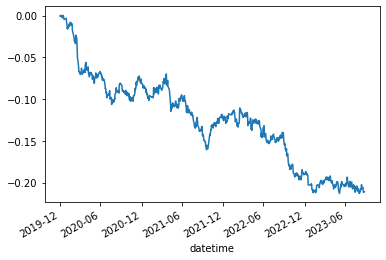

In [49]:
plot_cumret(lr_preds_df, 0.001, -0.001, if_random_trade=True)

In [51]:
# LGBM
def create_rolling_window(df, window_size, shift_size, feature_columns):
    df = df.copy()
    for feature in feature_columns:
        for i in range(1, window_size + 1):
            df[f'{feature}_rolling_{i}'] = df.groupby(level='instrument')[feature].shift(i * shift_size)
    return df

# lgbm
df_nona = df.dropna(axis=0, subset=['LABEL0'])
df_nona = create_rolling_window(df_nona, 22, 1, features)
new_features = df_nona.columns.difference(['LABEL0'])

/tmp/ipykernel_1933/906735031.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_rolling_{i}'] = df.groupby(level='instrument')[feature].shift(i * shift_size)
/tmp/ipykernel_1933/906735031.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_rolling_{i}'] = df.groupby(level='instrument')[feature].shift(i * shift_size)
/tmp/ipykernel_1933/906735031.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [ ]:
# build train, valid, test set
all_dates_set = get_periods('2020-01-01', '2023-09-30', 90, 90, 360 * 8)
all_preds = []
for subset in tqdm(all_dates_set):
    train_start, train_end = subset['train_period']
    valid_start, valid_end = subset['valid_period']
    test_start, test_end = subset['test_period']
    train_set = df_nona.loc[(df_nona.index.get_level_values('datetime') >= train_start) & (df_nona.index.get_level_values('datetime') <= train_end)]
    valid_set = df_nona.loc[(df_nona.index.get_level_values('datetime') >= valid_start) & (df_nona.index.get_level_values('datetime') <= valid_end)]
    test_set = df_nona.loc[(df_nona.index.get_level_values('datetime') >= test_start) & (df_nona.index.get_level_values('datetime') <= test_end)]
    # build a lgbm model
    train_set = lgb.Dataset(train_set[new_features], label=train_set['LABEL0'])
    valid_set = lgb.Dataset(valid_set[new_features], label=valid_set['LABEL0'])
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'num_leaves': 31,
        'learning_rate': 0.02,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 20,
        'verbose': 0,
        'n_jobs': -1,
    }
    model = lgb.train(params, train_set, num_boost_round=1000, valid_sets=[valid_set], early_stopping_rounds=50, verbose_eval=20)
    # predict
    test_set['pred'] = model.predict(test_set[new_features])
    all_preds.append(test_set[['pred', 'LABEL0']].rename(columns={'LABEL0': 'actual'}).reset_index())

  0%|          | 0/16 [00:00<?, ?it/s]/root/miniconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/root/miniconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
lgbm_preds_df = pd.concat(all_preds)
lgbm_preds_df.to_pickle('./lgbm_preds_df.pkl')
plot_cumret(lgbm_preds_df, 0.001, -0.001)